# Деревья решений решают проблемы
__Суммарное количество баллов: 10__

Вы уже знакомы с классификацией методом KNN. В этом задании предстоит реализовать другой метод классификации - дерево решений. 

Одной из его особенностей является возможность объяснить в человекочитаемой форме, почему мы отнесли объект к определенному классу. Эта особенность позволяет использовать деревья решений для создания систем, которые могут подсказывать специалистам, на что именно стоит обратить внимание при принятии решений.

In [63]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib
from collections import Counter

### Задание 1 (1 балл)
Во время построения дерева решений нам потребуется определить, какой из предикатов лучше всего разбивает обучающую выборку. Есть два критерия, которые позволяют это сделать: критерий Джини и энтропийный критерий. Первый для подсчета информативности разбиения использует коэффициент Джини, второй - энтропию. Реализуйте подсчет этих коэффициентов, а так же подсчет информативности разбиения. 

#### Описание функций
`gini(x)` считает коэффициент Джини для массива меток

`entropy(x)` считает энтропию для массива меток

`gain(left_y, right_y, criterion)` считает информативность разбиения массива меток на левую `left_y` и правую `right_y` части при помощи `criterion`, который задается функцией (не строкой).

In [64]:
def gini(x):
    hist = np.bincount(x)
    ps = hist / len(x)
    return np.sum([p * (1 - p) for p in ps])
    
def entropy(x):
    hist = np.bincount(x)
    ps = hist / len(x)
    return -np.sum([p * np.log2(p) for p in ps if p > 0])

def gain(left_y, right_y, criterion):
    y = list(left_y) + list(right_y)
    parent_impurity = criterion(y)
    if len(left_y) == 0 or len(right_y) == 0:
        return 0
    else:
        n = len(y)
        n_l, n_r = len(left_y), len(right_y)
        im_l, im_r = criterion(left_y), criterion(right_y)
        child_impurity = (n_l / n) * im_l + (n_r / n) * im_r
        ig = parent_impurity - child_impurity
        return ig

### Задание 2 (1 балл)
Деревья решений имеют хорошую интерпретируемость, т.к. позволяют не только предсказать класс, но и объяснить, почему мы предсказали именно его. Например, мы можем его нарисовать. Чтобы сделать это, нам необходимо знать, как оно устроено внутри. Реализуйте классы, которые будут задавать структуру дерева. 

#### DecisionTreeLeaf
Поля:
1. `y` должно содержать класс, который встречается чаще всего среди элементов листа дерева

#### DecisionTreeNode
В данной домашней работе мы ограничемся порядковыми и количественными признаками, поэтому достаточно хранить измерение и значение признака, по которому разбиваем обучающую выборку.

Поля:
1. `split_dim` измерение, по которому разбиваем выборку
2. `split_value` значение, по которому разбираем выборку
3. `left` поддерево, отвечающее за случай `x[split_dim] < split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`
4. `right` поддерево, отвечающее за случай `x[split_dim] >= split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

__Интерфейс классов можно и нужно менять при необходимости__ (например, для вычисления вероятности в следующем задании)

In [65]:
'''
class DecisionTreeLeaf:
    def __init__(self):
        self.y = None
        raise NotImplementedError()
'''

class DecisionTreeNode:
    def __init__(self, split_dim=None, split_value=None, left=None, right=None, value=None, proba=None):
        self.split_dim = split_dim
        self.split_value = split_value
        self.left = left
        self.right = right
        self.value = value
        self.proba = proba
        
    def is_leaf(self):
        return self.value is not None

### Задание 3 (6 баллов)
Теперь перейдем к самому дереву решений. Реализуйте класс `DecisionTreeClassifier`.

#### Описание методов
`fit(X, y)` строит дерево решений по обучающей выборке.

`predict_proba(X)` для каждого элемента из `X` возвращает словарь `dict`, состоящий из пар `(класс, вероятность)`. Вероятности классов в листе можно определить через количество объектов соответствующего класса в листе. 

#### Описание параметров конструктора
`criterion="gini"` - задает критерий, который будет использоваться при построении дерева. Возможные значения: `"gini"`, `"entropy"`.

`max_depth=None` - ограничение глубины дерева. Если `None` - глубина не ограничена

`min_samples_leaf=1` - минимальное количество элементов в каждом листе дерева.

#### Описание полей
`root` - корень дерева. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

In [66]:
class DecisionTreeClassifier:
    def __init__(self, criterion="gini", max_depth=100, min_samples_leaf=2, n_features=None):
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.n_features = n_features
        self.root = None
    
    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(self.n_features, X.shape[1])
        self.root = self.make_tree(X, y)
    
    def predict_proba(self, X):
        return np.array([self.traverse_tree_proba(x, self.root) for x in X])
    
    def predict(self, X):
        proba = self.predict_proba(X)
        return [max(p.keys(), key=lambda k: p[k]) for p in proba]
        #return np.array([self.traverse_tree(x, self.root) for x in X])
    
    def make_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        if (depth >= self.max_depth and self.max_depth is not None) or n_labels == 1 or n_samples < self.min_samples_leaf:
            leaf_value, leaf_proba = self.most_common_label(y)
            return DecisionTreeNode(value=leaf_value, proba=leaf_proba)

        feature_indices = np.random.choice(n_features, self.n_features, replace=False)

        best_feature, best_threshold = self.best_criterium(X, y, feature_indices)
        
        left_indices, right_indices = self.split(X[:, best_feature], best_threshold)
        left = self.make_tree(X[left_indices, :], y[left_indices], depth+1)
        right = self.make_tree(X[right_indices, :], y[right_indices], depth+1)
        return DecisionTreeNode(split_dim=best_feature, split_value=best_threshold, left=left, right=right)
    
    def best_criterium(self, X, y, feature_indices):
        best_gain = -1
        split_index, split_threshold = None, None
        if self.criterion == 'gini':
            for feature_index in feature_indices:
                X_column = X[:, feature_index]
                thresholds = np.unique(X_column)
                for threshold in thresholds:
                    left_indices, right_indices = self.split(X_column, threshold)
                    info_gain = gain(y[left_indices], y[right_indices], gini)
                    if info_gain > best_gain:
                        best_gain = info_gain
                        split_index = feature_index
                        split_threshold = threshold
            return split_index, split_threshold
        elif self.criterion == 'entropy':
            for feature_index in feature_indices:
                X_column = X[:, feature_index]
                thresholds = np.unique(X_column)
                for threshold in thresholds:
                    left_indices, right_indices = self.split(X_column, threshold)
                    info_gain = gain(y[left_indices], y[right_indices], entropy)
                    if info_gain > best_gain:
                        best_gain = info_gain
                        split_index = feature_index
                        split_threshold = threshold
            return split_index, split_threshold
        
    def split(self, X_column, split_threshold):
        left_indices = np.argwhere(X_column <= split_threshold).flatten()
        right_indices = np.argwhere(X_column > split_threshold).flatten()
        return left_indices, right_indices
    
    def traverse_tree(self, x, node):
        if node.is_leaf():
            return node.value

        if x[node.split_dim] <= node.split_value:
            return self.traverse_tree(x, node.left)
        return self.traverse_tree(x, node.right)
    
    def most_common_label(self, y):
        probabilities = {}
        counter = Counter(y)
        if counter == Counter():
            return 1, probabilities
        else:
            most_common = counter.most_common(1)[0][0]
            probabilities = {k: v/sum(counter.values()) for k, v in counter.items()}
            return most_common, probabilities
        
    def traverse_tree_proba(self, x, node):
        if node.is_leaf():
            return node.proba

        if x[node.split_dim] <= node.split_value:
            return self.traverse_tree_proba(x, node.left)
        return self.traverse_tree_proba(x, node.right)

Построенное дерево можно нарисовать. Метод `draw_tree` рисует дерево и сохраняет его в указанный файл.

In [67]:
def tree_depth(tree_root):
    if not tree_root.is_leaf():
    #if isinstance(tree_root, DecisionTreeNode):
        return max(tree_depth(tree_root.left), tree_depth(tree_root.right)) + 1
    else:
        return 1

def draw_tree_rec(tree_root, x_left, x_right, y):
    x_center = (x_right - x_left) / 2 + x_left
    if not tree_root.is_leaf():
    #if isinstance(tree_root, DecisionTreeNode):
        x_center = (x_right - x_left) / 2 + x_left
        x = draw_tree_rec(tree_root.left, x_left, x_center, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        x = draw_tree_rec(tree_root.right, x_center, x_right, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        plt.text(x_center, y, "x[%i] < %f" % (tree_root.split_dim, tree_root.split_value),
                horizontalalignment='center')
    else:
        plt.text(x_center, y, str(tree_root.value),
                horizontalalignment='center')
    return x_center

def draw_tree(tree, save_path=None):
    td = tree_depth(tree.root)
    plt.figure(figsize=(0.33 * 2 ** td, 2 * td))
    plt.xlim(-1, 1)
    plt.ylim(0.95, td + 0.05)
    plt.axis('off')
    draw_tree_rec(tree.root, -1, 1, td)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

Для двумерного набора данных дерево можно отобразить на плоскости с данными. Кроме того, как и для любого классификатора, для него можно построить roc-кривую

In [68]:
def plot_roc_curve(y_test, p_pred):
    positive_samples = sum(1 for y in y_test if y == 0)
    tpr = []
    fpr = []
    for w in np.arange(-0.01, 1.02, 0.01):
        y_pred = [(0 if p.get(0, 0) > w else 1) for p in p_pred]
        tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
        fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
    plt.figure(figsize = (7, 7))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

def rectangle_bounds(bounds):
    return ((bounds[0][0], bounds[0][0], bounds[0][1], bounds[0][1]), 
            (bounds[1][0], bounds[1][1], bounds[1][1], bounds[1][0]))

def plot_2d_tree(tree_root, bounds, colors):
    if not tree_root.is_leaf():
    #if isinstance(tree_root, DecisionTreeNode):
        if tree_root.split_dim:
            plot_2d_tree(tree_root.left, [bounds[0], [bounds[1][0], tree_root.split_value]], colors)
            plot_2d_tree(tree_root.right, [bounds[0], [tree_root.split_value, bounds[1][1]]], colors)
            plt.plot(bounds[0], (tree_root.split_value, tree_root.split_value), c=(0, 0, 0))
        else:
            plot_2d_tree(tree_root.left, [[bounds[0][0], tree_root.split_value], bounds[1]], colors)
            plot_2d_tree(tree_root.right, [[tree_root.split_value, bounds[0][1]], bounds[1]], colors)
            plt.plot((tree_root.split_value, tree_root.split_value), bounds[1], c=(0, 0, 0))
    else:
        x, y = rectangle_bounds(bounds)
        plt.fill(x, y, c=colors[tree_root.value] + [0.2])

def plot_2d(tree, X, y):
    plt.figure(figsize=(9, 9))
    colors = dict((c, list(np.random.random(3))) for c in np.unique(y))
    bounds = list(zip(np.min(X, axis=0), np.max(X, axis=0)))
    plt.xlim(*bounds[0])
    plt.ylim(*bounds[1])
    plot_2d_tree(tree.root, list(zip(np.min(X, axis=0), np.max(X, axis=0))), colors)
    for c in np.unique(y):
        plt.scatter(X[y==c, 0], X[y==c, 1], c=[colors[c]], label=c)
    plt.legend()
    plt.tight_layout()
    plt.show()

## Задание 4 (2 балла)

Протестируйте решение на данных cancer и spam (датасеты из директории `hw2_data`).
Выполните загрузку и предобработку данных.


Если необходимо, попробуйте разные наборы параметров для получения лучшего результата.

Посчитайте метрики `precision`, `recall`, `accuracy` для модели дерева.
Сравните значения метрик с результатами модели kNN из предыдущего задания (можно использовать реализацию из библиотеки `sklearn`). 

Какой нужен препроцессинг данных для моделей?
Какая модель делает предсказания лучше?  Предположите, почему.

Для датасета cancer для обоих моделей нужно перекодировать метки классов на числовые (0 и 1), а также разбить данные на тренировочную и тестовую часть. Для датасета spam для обоих моделей нужно разбить данные на тренировочную и тестовую часть. Для модели kNN нужно также нормализовать данные, поскольку эта модель работает с расстоянием между точками.
Судя по метрикам, модель decision tree лучше делает предсказания на датасете spam, чем kNN. Возможно, это происходит потому, что decision tree чувствительна к "взаимодействию" отдельных признаков, тогда как kNN "смотрит" на все сразу, оперируя с расстоянием. Однако на датасете cancer лучше работает kNN. Возможно, здесь играет роль то, что decision tree хуже работает с несбалансированными классами.

In [69]:
from sklearn.metrics import accuracy_score, \
                            recall_score, precision_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

Датасет cancer:

In [72]:
cancer_data = pd.read_csv('./hw2_data/cancer.csv') 
X = cancer_data.drop('label', axis=1).values 
y = cancer_data['label'].values 
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Accuracy: 0.9473684210526315
Recall: 0.8809523809523809
Precision: 0.9736842105263158


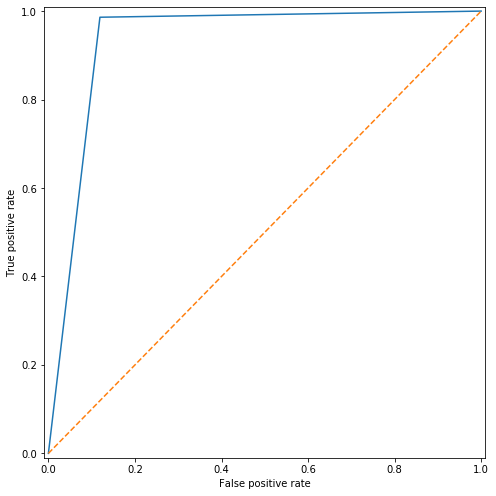

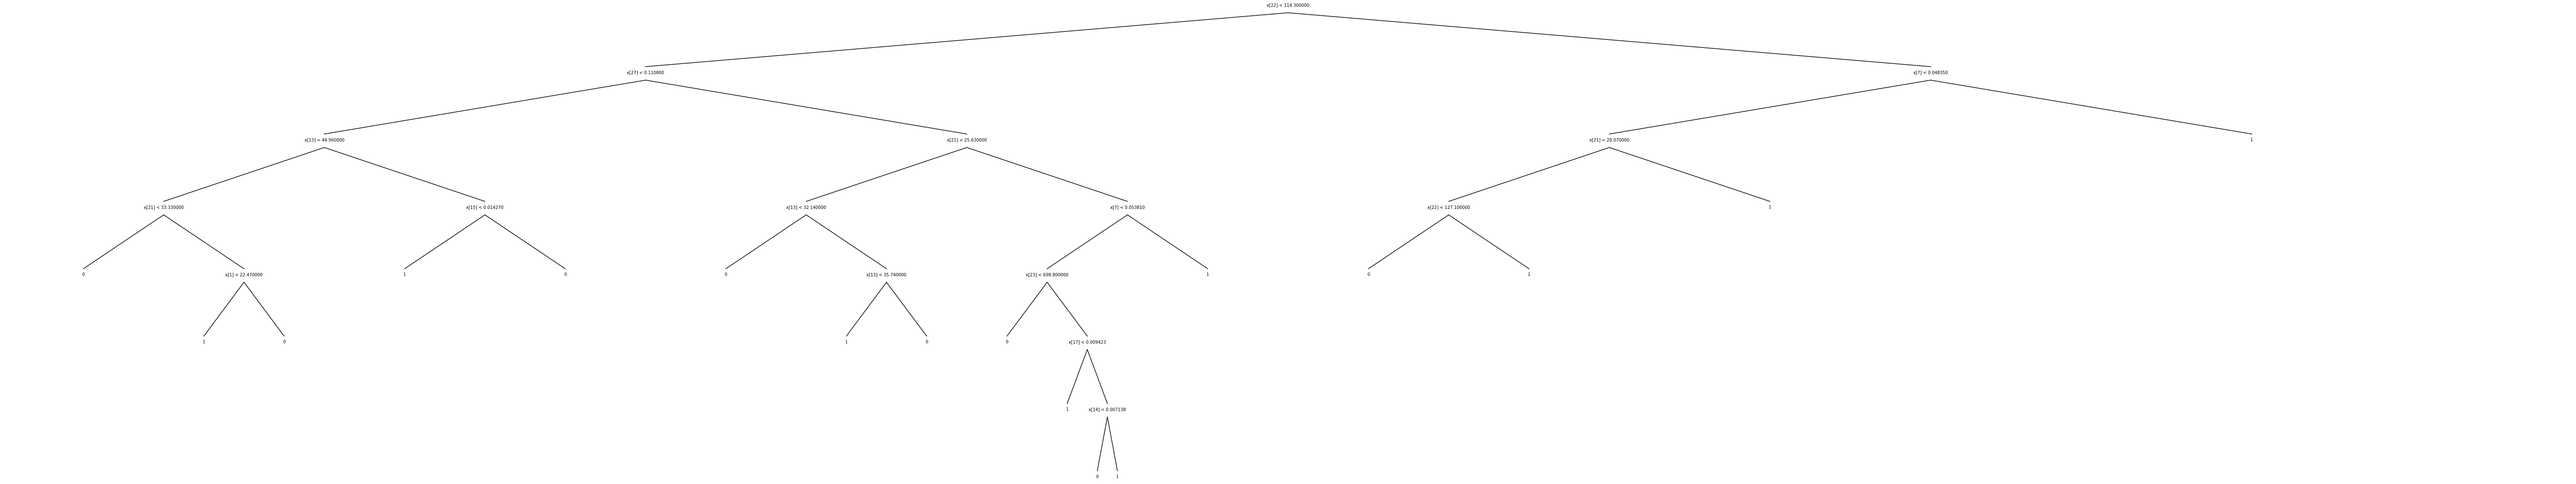

In [73]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_leaf=1)
tree.fit(X_train, y_train)
predicted = tree.predict(X_test)
acc = accuracy_score(y_test, predicted)
recall = recall_score(y_test, predicted)
prec = precision_score(y_test, predicted)
print(f'Accuracy: {acc}')
print(f'Recall: {recall}')
print(f'Precision: {prec}')
plot_roc_curve(y_test, tree.predict_proba(X_test))
draw_tree(tree)

In [74]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [75]:
knc = KNeighborsClassifier(n_neighbors=5, algorithm='kd_tree')
knc.fit(X_train, y_train)
predicted = knc.predict(X_test)
acc = accuracy_score(y_test, predicted)
recall = recall_score(y_test, predicted)
prec = precision_score(y_test, predicted)
print(f'Accuracy: {acc}')
print(f'Recall: {recall}')
print(f'Precision: {prec}')

Accuracy: 0.956140350877193
Recall: 0.9047619047619048
Precision: 0.9743589743589743


Датасет spam:

In [76]:
spam_data = pd.read_csv('./hw2_data/spam.csv') 
X = spam_data.drop('label', axis=1).values 
y = spam_data['label'].values 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Accuracy: 0.9315960912052117
Recall: 0.9008264462809917
Precision: 0.923728813559322


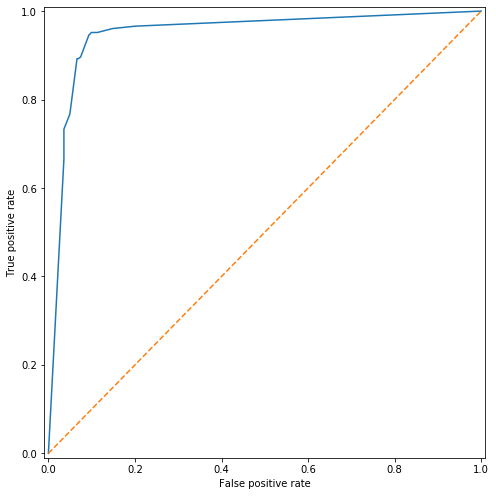

In [77]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=1)
tree.fit(X_train, y_train)
predicted = tree.predict(X_test)
acc = accuracy_score(y_test, predicted)
recall = recall_score(y_test, predicted)
prec = precision_score(y_test, predicted)
print(f'Accuracy: {acc}')
print(f'Recall: {recall}')
print(f'Precision: {prec}')
plot_roc_curve(y_test, tree.predict_proba(X_test))
draw_tree(tree)

In [78]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [79]:
knc = KNeighborsClassifier(n_neighbors=5, algorithm='kd_tree')
knc.fit(X_train, y_train)
predicted = knc.predict(X_test)
acc = accuracy_score(y_test, predicted)
recall = recall_score(y_test, predicted)
prec = precision_score(y_test, predicted)
print(f'Accuracy: {acc}')
print(f'Recall: {recall}')
print(f'Precision: {prec}')

Accuracy: 0.9022801302931596
Recall: 0.8650137741046832
Precision: 0.8845070422535212
